<a href="https://colab.research.google.com/github/jonathanbutler7/titanic/blob/main/Airline_Tweets_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Dependencies

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re  # For text cleaning
import string

# Download NLTK resources (run once)
nltk.download('punkt')  # Tokenizer
nltk.download('punkt_tab')
nltk.download('stopwords')  # Stopwords list


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load Data

Key Fields

- `airline_sentiment` : Sentiment classification (positive | neutral | negative)
- `negativereason` : Reason selected for the negative opinion
- `airline` : Name of 6 US Airlines ('Delta', 'United', 'Southwest', 'US Airways', 'Virgin America', 'American')
- `text` : Customer's opinion (tweet)


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/satyajeetkrjha/kaggle-Twitter-US-Airline-Sentiment-/refs/heads/master/Tweets.csv')
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# EDA

Analyze the provided dataset to gain a deeper understanding of what it contains. Make sure you can answer high level questions about the data.

For example:
- How many tweets reference each airline?
- Which airline has the best reputation?
- What is the biggest complaint for each airline?

These are not the only questions you should answer about the dataset, instead they are meant as a starting point to help you begin thinking about the problem.

In [ ]:
# how many tweets reference each airline?

print((df['retweet_count'] != 0).sum()) # 767 rows where retweet count is not zero.

df.value_counts('airline') # united has the most tweets, virgin america has the fewest


767


,count
airline,
United,3822
US Airways,2913
American,2759
Southwest,2420
Delta,2222
Virgin America,504


In [ ]:
# which airline has the best reputation?
sentiment_counts = df.groupby(['airline', 'airline_sentiment']).size()

# print("\n")
# print("Negative, neutral, positive, for each airline:")
# print(sentiment_counts)
# print("\n")

df_agg = sentiment_counts.unstack(fill_value=0)
df_agg['total_tweets'] = df_agg['negative'] + df_agg['neutral'] + df_agg['positive']
df_agg['positive_percent'] = df_agg['positive'] / df_agg['total_tweets'] * 100
df_agg['negative_percent'] = df_agg['negative'] / df_agg['total_tweets'] * 100
df_agg['positive_negative_ratio'] = df_agg['positive_percent'] / df_agg['negative_percent']
df_agg['net_score'] = (df_agg['positive'] - df_agg['negative']) / df_agg['total_tweets']

# this df allows multiple ways of defining "reputation".
# for example, you could sort by highest positive percent, or lowest negative percent
# additionally, you could also sort by net_score which takes into account positive,
# negative, and total_tweets
df_agg.sort_values(by='negative_percent', ascending=False)

airline_sentiment,negative,neutral,positive,total_tweets,positive_percent,negative_percent,positive_negative_ratio,net_score
airline,,,,,,,,
US Airways,2263,381,269,2913,9.234466,77.686234,0.118869,-0.684518
American,1960,463,336,2759,12.178325,71.040232,0.171429,-0.588619
United,2633,697,492,3822,12.872841,68.890633,0.186859,-0.560178
Southwest,1186,664,570,2420,23.553719,49.008264,0.480607,-0.254545
Delta,955,723,544,2222,24.482448,42.979298,0.569634,-0.184968
Virgin America,181,171,152,504,30.158730,35.912698,0.839779,-0.057540


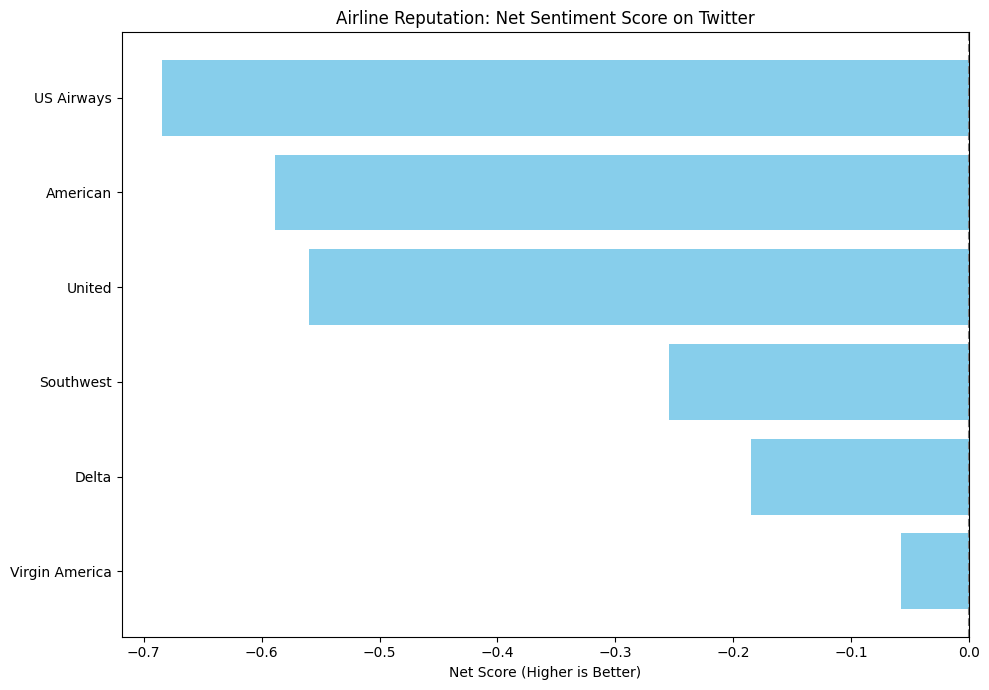

In [ ]:
import matplotlib.pyplot as plt

final_ranking_sorted = df_agg.sort_values(by='net_score', ascending=False)
plt.figure(figsize=(10, 7))
plt.barh(final_ranking_sorted.index, final_ranking_sorted['net_score'], color='skyblue')
plt.title('Airline Reputation: Net Sentiment Score on Twitter')
plt.xlabel('Net Score (Higher is Better)')
plt.axvline(x=0, color='grey', linestyle='--') # Add a line at zero for reference
plt.tight_layout()
plt.savefig('airline_reputation_score.png')

In [ ]:
# what is the biggest complaint for each airline?


print(df.value_counts('negativereason')) # 10 negative reasons, biggest negative reason with 2910 is Customer Service

reasons = df.groupby(['airline', 'negativereason']).size().reset_index(name='counts')

# Find the row with the maximum count per airline
biggest_complaints = reasons.loc[reasons.groupby('airline')['counts'].idxmax()]

# Sort by airline for consistent display (optional)
biggest_complaints = biggest_complaints.sort_values('airline').reset_index(drop=True)

# Display the results in a clean table format
print("\nBiggest complaint for each airline:")
biggest_complaints




negativereason
Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: count, dtype: int64

Biggest complaint for each airline:


,airline,negativereason,counts
0,American,Customer Service Issue,768
1,Delta,Late Flight,269
2,Southwest,Customer Service Issue,391
3,US Airways,Customer Service Issue,811
4,United,Customer Service Issue,681
5,Virgin America,Customer Service Issue,60


# Predictor

Remember, you do not need to code your predictor from scratch. You may use prebuilt tools and packages such as `nltk` or similar.

In [ ]:
# !pip install nltk scikit-learn ... etc

In [ ]:
# drop columns that don't seem relevant
df = df.drop(columns=['name', 'tweet_location', 'user_timezone'], axis=1)

# drop empty rows with missing text or sentiment
df = df.dropna(subset=['text', 'airline_sentiment'])

df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,negativereason_gold,retweet_count,text,tweet_coord,tweet_created
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800


In [ ]:
# preprocess the text
stop_words = set(stopwords.words("english"))

negation_words = set([
    'not', 'no', 'never', 'none', 'nobody', 'nothing', 'nowhere', 'hardly',
    'scarcely', 'barely', 'seldom', 'rarely', 'don\'t', 'isn\'t', 'wasn\'t',
    'shouldn\'t', 'wouldn\'t', 'couldn\'t', 'won\'t', 'ain\'t', 'can\'t',
    'doesn\'t', 'didn\'t', 'haven\'t', 'hasn\'t', 'hadn\'t', 'weren\'t',
    'mightn\'t', 'mustn\'t', 'needn\'t', 'shan\'t', 'wont', 'cant', 'didnt',
    'doesnt', 'isnt', 'wasnt', 'werent', 'shouldnt', 'wouldnt', 'couldnt',
    'havent', 'hasnt', 'hadnt'
])

stemmer = PorterStemmer()

def preprocess_text(text):
  # lower case the text
  text = text.lower()

  # tried this but it did not have a significant impact on the model
  # Replace emojis with their text description (e.g., ":)" becomes "smile")
  # Using a simple regex for demonstration, more robust libraries exist
  # text = re.sub(r':-?\)', ' smile ', text)
  # text = re.sub(r':-?\(', ' frown ', text)
  # text = re.sub(r':-?D', ' laugh ', text)
  # text = re.sub(r';-?\)', ' wink ', text)
  # text = re.sub(r':-?/', ' skeptical ', text)
  # text = re.sub(r'<3', ' heart ', text)

  text = re.sub(r"won't", "will not", text)
  text = re.sub(r"can't", "can not", text)
  text = re.sub(r"n't", "not", text)
  text = re.sub(r"'re", " are", text)
  text = re.sub(r"'s", "is", text)
  text = re.sub(r"'d", "would", text)
  text = re.sub(r"'ll", "will", text)
  text = re.sub(r"'t", " not", text)
  text = re.sub(r"'ve", " have", text)
  text = re.sub(r"'m", " am", text)

  text = re.sub(r'http\S+|www\S+|https\S+', '', text) # URLs
  text = re.sub(r'@\w+', '', text) # Handles like @VirginAmerica
  text = re.sub(r'#\w+', '', text) # Hashtags
  text = text.translate(str.maketrans('', '', string.punctuation)) # Punctuation
  text = re.sub(r'\d+', '', text) # Numbers

  tokens = word_tokenize(text)

  processed_tokens = []
  negate = False
  for token in tokens:
    if token in negation_words:
      negate = True
      processed_tokens.append(token)
      continue
    if negate:
      token.replace("_not", "")
      processed_tokens.append(token + '_not')
    else:
      processed_tokens.append(token)

  # remove stopwords and stem
  final_tokens = [stemmer.stem(word)
                  for word in processed_tokens
                  if word not in stop_words
                  and word.isalpha()
                  or word.endswith('_not')]

  # Join back into string
  return ' '.join(final_tokens)

df['cleaned_text'] = df['text'].apply(preprocess_text)

df[['text', 'cleaned_text']].head()

,text,cleaned_text
0,@VirginAmerica What @dhepburn said.,said
1,@VirginAmerica plus you've added commercials t...,plu ad commerci experi tacki
2,@VirginAmerica I didn't today... Must mean I n...,didnot today must mean need take anoth trip
3,@VirginAmerica it's really aggressive to blast...,iti realli aggress blast obnoxi entertain gues...
4,@VirginAmerica and it's a really big bad thing...,iti realli big bad thing


In [ ]:
X = df['cleaned_text']
y = df['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [ ]:
model = LogisticRegression(max_iter=200, class_weight='balanced')
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7561475409836066
              precision    recall  f1-score   support

    negative       0.89      0.80      0.84      1835
     neutral       0.53      0.68      0.60       620
    positive       0.68      0.70      0.69       473

    accuracy                           0.76      2928
   macro avg       0.70      0.73      0.71      2928
weighted avg       0.78      0.76      0.76      2928



In [ ]:
# view misclassified tweets
misclassified_idx = X_test[y_test != y_pred].index

# Create a DataFrame with original text, actual label, and predicted label
errors_df = df.loc[misclassified_idx, ['text', 'airline_sentiment']].copy()
errors_df['predicted'] = y_pred[y_test != y_pred]  # Align predictions with the errors

# Reset index for clean display (optional)
errors_df = errors_df.reset_index(drop=True)

# Print the first 20 misclassifications (adjust as needed)
print("Misclassified Tweets:")
errors_df.head(20)

# Optional: Save to CSV for further review
errors_df.to_csv('misclassified_tweets.csv', index=False)

Misclassified Tweets:


In [ ]:
new_tweet = "@AmericanAir a school trip of 38 including myself had to sleep over in the airport and are all on different standby flights. This is not good"
cleaned = preprocess_text(new_tweet)
vec = vectorizer.transform([cleaned])
print("Predicted:", model.predict(vec)[0])

Predicted: neutral
